# Random Number Generation

Random number genaration is the process of generating random numbers. This can mean the generation of one random number or a sequence of random numbers. Random number generators are devices which produce random numbers. There are hardware random number generators, which are true random number generators. And there are pseudo-random number generators (PRNG), which produce sequences of radnom numbers that look random but are in effect not random and can be reproduced if the state of the PRNG is known. PRNG are often implemented in software.

The generation of random numbers with software is usually not truely random in it's nature. Why is that? Mainly because a computer doesn't have enough "randomness" available to generate large sequences of random numbers. Surely, there is a enough randomness to generate a random number "every now and then". Just take the milliseconds of the current system time, e.g. to sample a random number from the uniform distribution over $[0, 1]$. However, often we want to generate sequences - and possibly even large sequences - of random numbers during a "non-random" time interval. While there are other sources of randomness available to a computer, like some hardware input, human input or network trafic, it's often not enough to provide "true randomness" for sampling many random numbers in short time intervals. 

For this purpose, PRNG generate number sequences that look random but are, in effect, deterministic. PRNG are usually initialized with a truely random number. However, the entropy of a sequence of pseudo-random numbers generated by a PRNG can't be higher than the entropy of the random initialization of the PRNG. The PRNG "cleverly" hides the relatively low entropy by making the number sequence look random. But it is not. Would we know the type of PRNG and its initialization, we could then easily recreate that particular number sequence. That's why these numbers are pseudo-random.

When we want to generate a random number, we want to sample that number from a particular distribution $P$. Most algorithms for sampling random numbers actually only require a sequence of random numbers $x_{i=1}^{n}$ from the uniform distribution over the real interval $[0, 1] \subseteq ℝ$. They then use $x_{i=1}^{n}$ to generate the random number from the desired distribution. There is a theoretical results which says that any distribution over the real number can be composed of the uniform distribution over $[0, 1]$ and a "gluing" function.

In other words, that means that we need to have a robust PRNG to generate a sequence of random numbers from the uniform distribution over $[0, 1]$. The "gluing" function we can then find in the form of a clever algorithm. 


## Linear Congruential Generator

Software PRNG are often recursive. That means that the calculation of the next number of the sequence involves the current number generated by the sequence. One example is the linear congruential  generator, which generates the next number like 

$$x_i = (a x_{i - 1} + b) \mod m$$

where $a,b,m \in ℕ$ and have to be set upon initialization and are

 * $0 < m$, the modulus
 * $0 < a < m$, the multiplier
 * $0 ≤ b < m$, the increment
 * $0 ≤ x_0 < m$, the start value or seed
 
Let's implement a linear congruential generator and use it to draw pseudo-random numbers that shall be equally distributed in the interval $[0, 1]$. 

In [284]:
from math import floor, log
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from typing import List

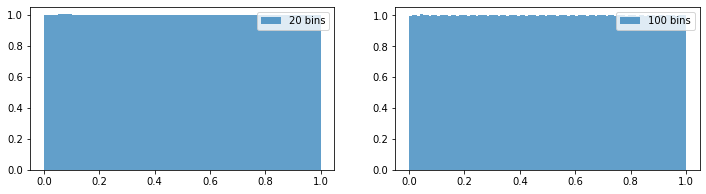

In [285]:
class RandUniform(object):
    def __init__(self, a: int = 106, b: int = 523, m: int = 9973, seed: int = 82):
        self.a = a
        self.b = b
        self.m = m
        self.last = seed
             
    def rvs(self, n: int) -> np.ndarray:
        return np.full(shape=(n,), fill_value=[self._next() for _ in range(n)]) * (1 / self.m)
    
    def _next(self) -> int:
        next = (self.a * self.last + self.b) % self.m
        self.last = next
        return next

    
rand_sample = RandUniform().rvs(n=1000000)

fig, axs = plt.subplots(1, 2, figsize=(12, 3))
axs[0].hist(rand_sample, density=True, bins=20, alpha=0.7, label='20 bins')
axs[1].hist(rand_sample, density=True, bins=100, alpha=0.7, label='100 bins')
axs[0].legend(), axs[1].legend()
plt.show()

## Inversion Sampling

Imagine a random variable $X:\Omega \rightarrow ℝ$ with $(\Omega, 𝒜, P)$ a probability space and $(ℝ, ℬ(ℝ))$ the Borrel Sigma-Algebra. $X$ induces a probability measure on $(ℝ, ℬ(ℝ))$ which can be uniquely characterized by its cummulative distribution function $F$ or almost uniquely by its probability density function $p$. Let's further assume that we know $p$ and that we want to sample from $p$. Inversion sampling proceeds as follows

 * Determine $F$ from $p$ 
 * Require $F$ to be strictly monotone
 * Determine inversion $F^{-1}$
 * We know that $F^{-1}$ has a range of $[0, 1]$
 * Sample $x$ from the uniform distribution over $[0, 1]$
 * $F^{-1}(x)$ is our random sample from $p$
 
Let's look at an example. Let $P$ have a standard Gumbel distribution with 
 * $p(x) = e^{-xe^{-x}}$
 * $F(x) = e^{-e^{-x}}$
 * $F^{-1}(y) = -log(-log(y))$


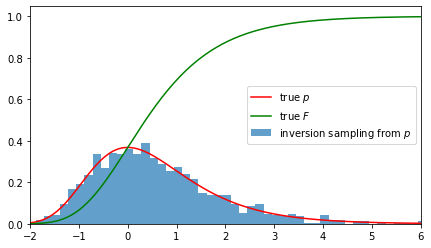

In [286]:
def p(x: float):
    return np.exp(-(x + np.exp(-x)))

def F(x: float):
    return np.exp(-np.exp(-x))

def F_inv(y: float):
    return -np.log(-np.log(y))

rand_uniform = RandUniform().rvs(n=1000)
rand_sample = np.vectorize(F_inv)(rand_uniform)

plt.figure(figsize=(7,4))
plt.xlim((-2, 6))
x = np.linspace(-2, 6, 200)
plt.plot(x, np.vectorize(p)(x), c='red', label='true $p$')
plt.plot(x, np.vectorize(F)(x), c='green', label='true $F$')
plt.hist(rand_sample, density='True', bins=50, label='inversion sampling from $p$', alpha=0.7)
plt.legend()
plt.show()

The Gumbel distribution is used to model the maximum or minimum of a number samples from various distributions. Its usefulness in this example is the fact that it is one of a few distribution where the inverse of it cummulative distribution function (CDF) can be given in a closed-form expression. Closed-form expressions for the inverse CDF are not so common. That means that often we have to calculate $F^{-1}$ numerically, which can be seen as a disadvantage of inversion sampling.

Inversion sampling probably also works for multivariate distributions. Like above, we have a random variable $X:\Omega \rightarrow ℝ^n$ with $n \in $ℕ, $(\Omega, 𝒜, P)$ a probability space and $(ℝ^n, ℬ(ℝ^n))$ the Borrel Sigma-Algebra. $X$ induces a probability measure on $(ℝ^n, ℬ(ℝ^n))$ which can again be uniquely characterized by its cummulative distribution function $F$ or almost uniquely by its probability density function $p$. Using the chain rule of probability we have

$$ p(x_1, ..., x_n) = p(x_1 | x_2, ..., x_n) * p(x_2, ..., x_n) $$

$$ p(x_1, ..., x_n) = p(x_1 | x_2, ..., x_n) * p(x_2 | x_3, ..., x_n) * ... * p(x_{n-1} | x_n) * p(x_n)$$

We could now begin with sampling $x_n$ from $p(x_n)$ using the univariate inversion sampling approach described above. Then we sample $x_{n-1}$ from $p(x_{n-1} | x_n)$ using the $x_n$ which we sampled before to define the conditional density. Then we sample $x_{n-2}$ from $p(x_{n-2} | x_{n-1}, x_n)$ and so forth until we sampled $x_n, ..., x_1$.

Inversion sampling, however, often requires to determine $F^{-1}$ numerically, which can be time consuming and inefficient. For this reason, inversion sampling is generally not used to sample from  complicated distributions. It is however, used, to sample from some standard distributions that are well-known. Like for example the normal distributions in the statistical programming language R. Note that there is no closed-form expression for the inversion of the CDF of the normal distribution.

## Rejection Sampling

Inversion sampling is impractical for many distributions since the inversion of the CDF has to be calcualted numerically: a process that can be very time-consuming and, probably, sometimes also inaccurate. Rejection sampling is an algortihm that doesn't require the calculation of the CDF inverse to sample from a distribution. Rejection sampling can be used to sample from any distribution.

To sample from a density $f$ with rejection sampling, we need:

 * a density $g$ from which we can sample already
 * a $k \in ℝ$ such that $kg$ is an upper bound to $f$ over the whole domain of $f$
 
Conceptionally, rejection sampling works as follows: 
 
 * Place $n$ points in the area between $kg$ and the x-axis randomly and equally
 * All $m ≤ n$ points which are also between $f$ and the x-axis are random samples from $f$
 
Technically, we do the following steps:

 * Draw a random sample $x$ from $g$
 * Draw a random sample $e$ from the uniform distribution over $[0, 1]$
 * Accept $x$ as random sample from $f$ if $ekg(x) < f(x)$, reject it else

In [361]:
f = stats.crystalball(beta=1, m=2)  # target
g = stats.norm(-2.5, 5)  # known
uniform = RandUniform()  # alternatively: uniform = stats.uniform()
uniform = stats.uniform()
k = 4.5
n = 10000



def plot_densities(ax):
    t = np.linspace(-10, 10, 100)
    ax.plot(t, f.pdf(t), label='f, sampling wanted', color='red')
    ax.plot(t, g.pdf(t), label='g, sampling possible', color='green')
    ax.plot(t, k*g.pdf(t), label='k*g ≥ f, upper bound', color='blue')
    ax.set_xlim((-10, 10))


def plot_samples_all(ax, col):
    u = uniform.rvs(n)
    x = g.ppf(u)  # inverse of cdf
    y = uniform.rvs(n) * k * g.pdf(x)

    s = slice(0, 500)
    ax.scatter(x[s], y[s], color=col, alpha=0.3, label='samples')
    ax.set_xlim((-10, 10))
        
    return x_accepted


def plot_samples_rejected_accepted(ax, col1, col2):
    n = 10000
    u = uniform.rvs(n)
    x = g.ppf(u)  # inverse of cdf
    y = uniform.rvs(n) * k * g.pdf(x)

    y_accepted = y[y < f.pdf(x)]
    x_accepted = x[y < f.pdf(x)]
    y_rejected = y[y >= f.pdf(x)]
    x_rejected = x[y >= f.pdf(x)]

    s1, s2 = _slice_accepted_rejected(len(x_accepted)/n, 500)
    ax.scatter(x_accepted[s1], y_accepted[s1], color=col1, alpha=0.3, label='accepted')
    ax.scatter(x_rejected[s2], y_rejected[s2], color=col2, alpha=0.3, label='rejected')
    ax.set_xlim((-10, 10))
        
    return x_accepted


def plot_hist(ax, x_accepted):
    ax.hist(x_accepted, density=True, alpha=0.5, bins=40, color='red', label='hist samples of $f$')
    

def _slice_accepted_rejected(prop_accepted, points):
    return slice(0, floor(prop_accepted * points)), slice(0, floor((1 - prop_accepted) * points))

Fraction rejected samples: 0.79


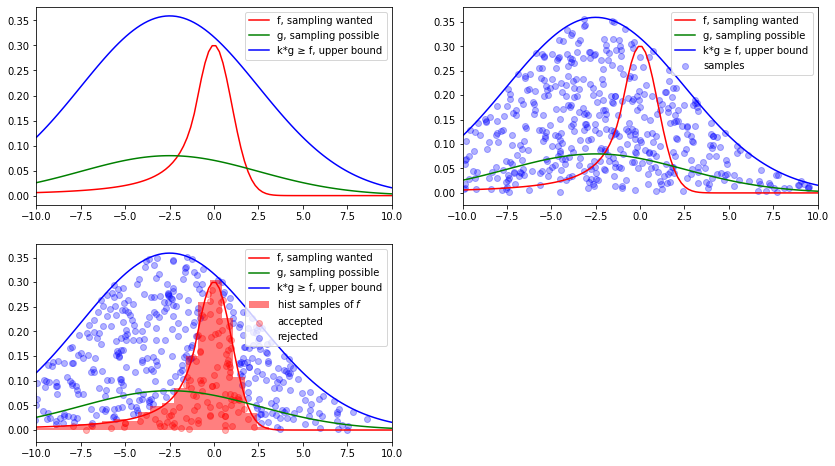

In [362]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))

plot_densities(axs[0, 0])
axs[0, 0].legend()

plot_densities(axs[0, 1])
plot_samples_all(axs[0, 1], 'blue')
axs[0, 1].legend()

plot_densities(axs[1, 0])
x_accepted = plot_samples_rejected_accepted(axs[1, 0], 'red', 'blue')
plot_hist(axs[1, 0], x_accepted)
axs[1, 0].legend()

axs[-1, -1].axis('off')

print(f'Fraction rejected samples: {len(x_rejected) / n:.3}')

An advantage of rejection sampling is that we can sample from $f$ quite easily once we have a function $g$ that acts as a good uper bound for $f$ through $kg$. On the other hand, finding a good function $g$ is not always easy. In rejection sampling we are basically sampling from $g$ and keeping those samples as samples from $f$ that don't get rejected. If our choice of $g$ is not a good "proxy" for $f$ we will reject a lot of samples, which will make sampling slow. 

Besides, if we want to sample in high-dimensional spaces, we run into the curse of dimensionality because rejection sampling has exponential time complexity w.r.t the number of dimensions. We might mitigate this a bit if we chose a good proxy $g$ but for complicated functions $f$ it is probably not so easy to find a good $g$. Keep in mind that we are basically sampling from $g$. This means that our first guess for $f$ is $g$. If $g$ is far away from $f$ rejection sampling becomes inefficient.

Rejection sampling is often used for sampling from one-dimensional distributions. For sampling in high-dimensional distributions it is not efficient anymore and other methods like the Metropolis-Hastings sampling algorithm are prefered.

## Metropolis-Hastings Sampling

Sampling from a particular distribution is desirable if we want to e.g. simulate the behavior of a system and we know the distribution of its "stochastic" components. However, there are also other use cases where we are interested in sampling from a particular distribution. 


### Bayes Inference with Metropolis-Hastings

One use case is infering the distribution of the posterior in Bayes inference statistics. In these cases we often have a closed-form expression for $p(\theta | x)$ but we don't really know how $p(\theta | x)$ behaves. Is it tightly centered around one value or multiple values? What are its summary statistics like expected value and variance? Theses problems are particularly pronounced if we are dealing with high-dimensional $\theta$. In this setting, we want to sample from $p(\theta | x)$ not for the purpose of drawing random samples per se but to better understand $p(\theta | x)$ and possibly infer quantities like $E[p(\theta | x)]$ or $\hat{\theta}_{MAP}$. 

The Metropolis-Hastings algorithm is a sampling algorithm that is often used in this setting. It has two properties that make it a good choice in the Bayes inference setting.

 1. It doesn't require calculating the "data" term "$p(x)$" in $p(\theta | x) = \frac{p(x | \theta)p(\theta)}{p(x)}$
 2. It is efficient in sampling from high-dimensional distributions (i.e. high-dimensional $\theta$), as oposed to other sampling algorithms like rejection sampling
 
On the other hand, it also has disadvantages. The main disadvantage is probably that random samples drawn with the Metropolis-Hastings algorithm are not independent from each other. This is a general disadvantage of the Metropolis-Hastings sampling algorithm, which is not particular for Bayes parameter inference.


### The Metropolos-Hastings Sampling Algorithm

In it's general form, the Metropolis-Hastings algorithm generates a sequence of samples from the distribution $p$. It does so through a Markov chain random walk. To draw the next sample $z_{t+1}$ from $p$ it needs the previously drawn sample $z_t$. Then a proposal distribution $g$  suggests $z'$ by sampling from $g(z | z_t)$. By some criterion $z'$ is either accepted in which case we set $z_{t+1} = z'$ or rejected, in which case we set $z_{t+1} = z_t$.

Remember that the Markov chain is a autoregressive process of order $1$ with $Z_{t+1} \perp \!\!\! \perp Z_{t-1} | Z_t$. The algorithm works as follows:

 * Let $g(z' | z_{t})$ be the proposal distribution that suggests $z'$ as the next step to move to from $z_t$
 * Pick initial state $z_0$
 * Iterate
  * Propose a candidate state $z'$ from $g(z' | z_{t})$ 
  * Calculate the acceptance probability $A(z', z_{t}) = \min(\frac{p(z')}{p(z_t)}\frac{g(z_t | z')}{g(z' | z_t)}, 1)$
  * Generate a random sample $u$ from the uniform distribution over $[0, 1]$
    * if $u ≤ A(z', z_{t})$, then accept $z'$ and set $z_{t + 1} = z'$
    * else, reject $z'$ and set $z_{t + 1} = z_t$
  * $t = t + 1$
  
 
 #### Simplifications for Bayes Inference
 
When using the Metropolis-Hastings algorithm for Bayes inference, we often use a symetrical proposal distribution $g$. That means that $\forall z', z: g(z' | z) = g(z | z')$. Then the calculation of the acceptance probability simplifies to 

$$ A(z', z_{t}) = \min(\frac{p(z')}{p(z_t)}, 1) $$
 
Furthermore, in Bayes inference we have $p(\theta | x) = \frac{p(x | \theta)p(\theta)}{p(x)}$. Note that we want to sample now $\theta$ instead of $z$ in the general formulation of the Metropolis-Hastings algorithm above. That simplifies the calculation of the acceptance probability to 

$$ A(\theta', \theta_{t}) = \min(\frac{p(\theta' | x)}{p(\theta | x)}, 1) = \min(\frac{p(x | \theta')p(\theta')/p(x)}{p(x | \theta)p(\theta)/p(x)}, 1) = \min(\frac{p(x | \theta')p(\theta')}{p(x | \theta)p(\theta)}, 1)$$

This is a significant advantage of the Metropolis-Hastings sampling algorithm for Bayes inference: we don't have to calculate the data term $p(x)$, which can be very hard. In practise we would need to calculate $p(x)$ through integrating out $\theta$ like

$$ p(x) = \int_{\theta} p(x | \theta) p(\theta) d\theta $$


### Examples

#### Sampling from Crystalball Distribution

In this example of the Metropolis-Hastings sampling algorithm we sample from the crystalball distribution. This example is not related to parameter estimation in Bayes inference statistics. It should rather illustrate the difference between Metropolis-Hastings sampling and rejection sampling, which was described above.

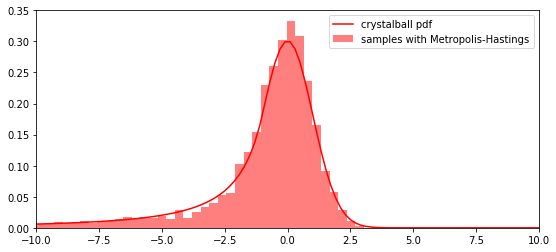

In [369]:
p = stats.crystalball(beta=1, m=2)  # target to sample from
g = stats.norm(0, 1)  # proposal distribution
uniform = RandUniform()

x = []
x_t = 0  # Markov chain initialization
x.append(x_t)
n = 5000

for i in range(n):
    x_prime = x_t + g.rvs(1)[0]
    a_criterion = min(p.pdf(x_prime) / p.pdf(x_t), 1)
    u = uniform.rvs(1)[0]
    if u < a_criterion:
        x_t = x_prime
    x.append(x_t)
       
plt.figure(figsize=(9, 4))
t = np.linspace(-10, 10, 100)
plt.plot(t, p.pdf(t), color='red', label='crystalball pdf')
plt.hist(x, bins=50, density='True', color='red', alpha=0.5, label='samples with Metropolis-Hastings')
plt.xlim(-10, 10)
plt.legend()

When we play around with the parameters of the Metropolis-Hastings sampling algorithm we see that the algorithm can behave quite differently. The parameters we can modify are

 * the average step size trough $\sigma$ of the proposal normal distribution $g$
 * the length of the chain $n$
 
Generally, we can say that the algorithm yields better results if the chain is longer. Usually, in Metropolis-Hastings sampling the first $m ≤ n$ elements of the chain are discared. The first elements in the Markov chain often seem to not be particularly representative of the sampled distribution. The length of $m$ depends on the particular application but values around $50,000$  are not uncommon. The period until the $m$-th sample is called the "burn in" period of the algorithm and might arise because of the choise of the initial value $z_0$. 

Eventually, the sequence sampled by the Metropolis-Hastings algorithm converges to the true distribution. However, the speed of divergence depends on both $p$ and $g$, and might not be obvious. There are techniques to inverstigate whether the algorithm has converged.


#### Metropolis Hastings Sampling for Bayes Inference

Portion of accepted steps = 0.192


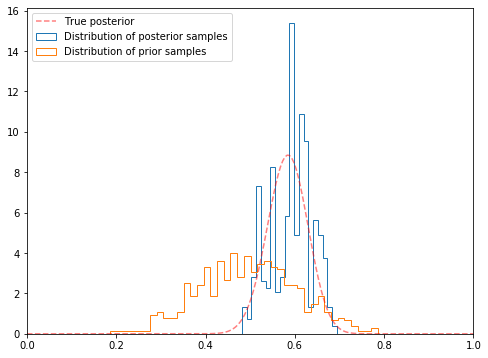

In [371]:
def target(likelihood, prior, n, h, theta):
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(n, theta).pmf(h)*prior.pdf(theta)


n = 100
h = 60
a = 10
b = 10

likelihood = stats.binom
prior = stats.beta(a, b)
sigma = 0.3

naccept = 0
theta = 0.1
niters = 1000

samples = np.zeros(niters+1)
samples[0] = theta

for i in range(niters):
    theta_p = theta + stats.norm(0, sigma).rvs()
    rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
    u = np.random.uniform()
    if u < rho:
        naccept += 1
        theta = theta_p
    samples[i+1] = theta


nmcmc = len(samples)//2
print("Portion of accepted steps = " + str(naccept/niters))


post = stats.beta(h+a, n-h+b)
thetas = np.linspace(0, 1, 200)

plt.figure(figsize=(8, 6))
plt.hist(samples[nmcmc:], 20, histtype='step', density=True, linewidth=1, label='Distribution of posterior samples');
plt.hist(prior.rvs(nmcmc), 40, histtype='step', density=True, linewidth=1, label='Distribution of prior samples');
plt.plot(thetas, post.pdf(thetas), c='red', linestyle='--', alpha=0.5, label='True posterior')
plt.xlim([0,1]);
plt.legend(loc='best');

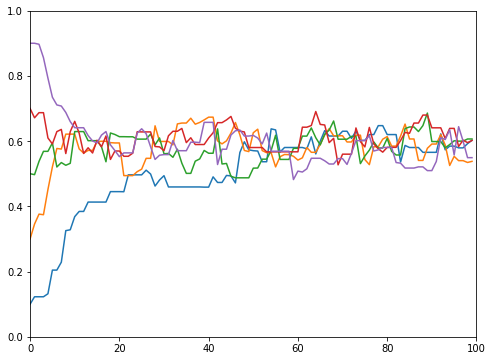

In [373]:
# ## Convergence diagnostics

def mh_coin(niters, n, h, theta, likelihood, prior, sigma):
    samples = [theta]
    while len(samples) < niters:
        theta_p = theta + stats.norm(0, sigma).rvs()
        rho = min(1, target(likelihood, prior, n, h, theta_p)/target(likelihood, prior, n, h, theta ))
        u = np.random.uniform()
        if u < rho:
            theta = theta_p
        samples.append(theta)
        
    return samples


n = 100
h = 61
lik = stats.binom
prior = stats.beta(a, b)
sigma = 0.05
niters = 100


chains = [mh_coin(niters, n, h, theta, likelihood, prior, sigma) for theta in np.arange(0.1, 1, 0.2)]


plt.figure(figsize=(8, 6))

for chain in chains:
    plt.plot(chain)
    
plt.xlim([0, niters])
plt.ylim([0, 1]);